In [8]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime

# in a notebook, load the tensorboard extension, not needed for scripts
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [9]:
(train_ds, test_ds), info_ds = tfds.load("cifar10", split = ["train", "test"], as_supervised = True, with_info = True)

In [11]:
def preprocessing(data):
  #convert data from uint8 to float32
  data = data.map(lambda img, target: (tf.cast(img, tf.float32), target))
  #sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
  data = data.map(lambda img, target: ((img/128.)-1., target))
  #create one-hot targets
  data = data.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
  #cache this progress in memory, as there is no need to redo it; it is deterministic after all
  data = data.cache()
  #shuffle, batch, prefetch
  data = data.shuffle(1000)
  data = data.batch(32)
  data = data.prefetch(20)
  #return preprocessed dataset
  return data


In [47]:
from tensorflow.keras.layers import Dense

class BasicConv(tf.keras.Model):
    def __init__(self):
        super(BasicConv, self).__init__()

        self.convlayer1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')
        self.convlayer2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')
        self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.convlayer3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')
        self.convlayer4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')
        self.pooling2 = tf.keras.layers.GlobalAveragePooling2D()

        self.out = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = self.pooling(x)
        x = self.convlayer3(x)
        x = self.convlayer4(x)
        x = self.pooling2(x)

        x = self.out(x)
        return x
    
    def train_step(self, input, target, loss_function, optimizer):

      with tf.GradientTape() as tape:
        prediction = self(input)
        loss = loss_function(target, prediction)
      gradients = tape.gradient(loss, self.trainable_variables)
      optimizer.apply_gradients(zip(gradients, self.trainable_variables))
      return loss

    def test(model, test_data, loss_function):
      test_accuracy_aggregator = []
      test_loss_aggregator = []

      for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy = np.mean(np.argmax(target, axis = 1) == np.argmax(prediction, axis=1))
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

      test_loss = tf.reduce_mean(test_loss_aggregator)
      test_accuracy = tf.reduce_mean(test_accuracy_aggregator)
      return test_loss, test_accuracy

    

In [66]:


def training_loop(model, data, optimizer, n_epochs, loss_function):

    train_losses = []
    test_losses = []
    test_accuracies = []

    train_data, test_data = data

    test_loss, test_accuracy = model.test(test_data, loss_function)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # testing on test data before begin
    train_loss, _ = model.test(train_data, loss_function)
    train_losses.append(train_loss)

    # train for epochs
    for epoch in range(n_epochs):
     
      print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]} testing loss {test_losses[-1]} and training loss {train_losses[-1]}')  

      epoch_loss_agg = []
      for input, target in train_data:
        train_loss = model.train_step(input, target, loss_function, optimizer)
        epoch_loss_agg.append(train_loss)

      train_losses.append(tf.reduce_mean(epoch_loss_agg))

      test_loss, test_accuracy = model.test(test_data, loss_function)
      test_losses.append(test_loss)
      test_accuracies.append(test_accuracy)

    x = [i for i in range(n_epochs + 1)]
    plt.plot(train_losses, label = "train loss")
    plt.plot(test_losses, label = "test loss")
    plt.plot(test_accuracies, label = "test accuracy")
    plt.legend()
    plt.show()

Epoch: 0 starting with accuracy 0.095625 testing loss 2.3084986209869385 and training loss 2.307509422302246
Epoch: 1 starting with accuracy 0.225 testing loss 2.056147575378418 and training loss 2.1803367137908936
Epoch: 2 starting with accuracy 0.2846875 testing loss 1.8923099040985107 and training loss 1.9961870908737183
Epoch: 3 starting with accuracy 0.3371875 testing loss 1.7683594226837158 and training loss 1.8445837497711182
Epoch: 4 starting with accuracy 0.335625 testing loss 1.7869606018066406 and training loss 1.7613961696624756
Epoch: 5 starting with accuracy 0.3503125 testing loss 1.680873155593872 and training loss 1.7023965120315552
Epoch: 6 starting with accuracy 0.3490625 testing loss 1.649543046951294 and training loss 1.6617296934127808
Epoch: 7 starting with accuracy 0.3884375 testing loss 1.6461913585662842 and training loss 1.6143815517425537
Epoch: 8 starting with accuracy 0.4259375 testing loss 1.566123366355896 and training loss 1.5838531255722046
Epoch: 9 sta

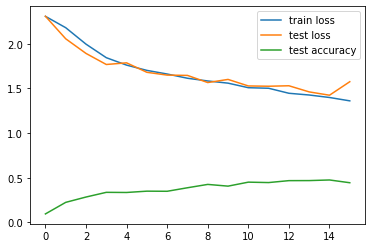

In [64]:
# this is the first architecture I used. Architercture: 2 covlayers with 32 filters, max pooling, 2 conv layers with 64 filters, global avg pooling, softmax
training_loop(model = BasicConv(), 
              data = (preprocessing(train_ds), preprocessing(test_ds)),
              optimizer = tf.keras.optimizers.Adam(),
              n_epochs = 15, 
              loss_function = tf.keras.losses.CategoricalCrossentropy())

Epoch: 0 starting with accuracy 0.09375 testing loss 2.3011138439178467 and training loss 2.301170587539673
Epoch: 1 starting with accuracy 0.14375 testing loss 2.2941036224365234 and training loss 2.2983694076538086
Epoch: 2 starting with accuracy 0.15 testing loss 2.2834670543670654 and training loss 2.289398431777954
Epoch: 3 starting with accuracy 0.1709375 testing loss 2.264920473098755 and training loss 2.2774147987365723
Epoch: 4 starting with accuracy 0.1734375 testing loss 2.236978054046631 and training loss 2.2570886611938477
Epoch: 5 starting with accuracy 0.1878125 testing loss 2.1976306438446045 and training loss 2.2218685150146484
Epoch: 6 starting with accuracy 0.2009375 testing loss 2.149747133255005 and training loss 2.183000326156616
Epoch: 7 starting with accuracy 0.225 testing loss 2.1052651405334473 and training loss 2.143336296081543
Epoch: 8 starting with accuracy 0.2128125 testing loss 2.0786521434783936 and training loss 2.105879783630371
Epoch: 9 starting with

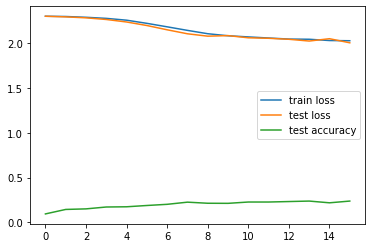

In [65]:
training_loop(model = BasicConv(), 
              data = (preprocessing(train_ds), preprocessing(test_ds)),
              optimizer = tf.keras.optimizers.SGD(),
              n_epochs = 15, 
              loss_function = tf.keras.losses.CategoricalCrossentropy())

In [35]:
# for this and the next training_run the architecture was: 2 conv layers with 34 filters, one max pooling layer, 2 convlayers with 64 filters, max pooling layer, 128 neuron relu layer, 10 softmax output
training_loop(model = BasicConv(),
              data = (preprocessing(train_ds), preprocessing(test_ds)),
              optimizer = tf.keras.optimizers.SGD(),
              n_epochs = 15, 
              loss_function = tf.keras.losses.CategoricalCrossentropy())

Epoch: 0 starting with accuracy 0.0896875 testing loss 2.3092799186706543 and training loss 2.308549404144287
Epoch: 1 starting with accuracy 0.18875 testing loss 2.269923210144043 and training loss 2.291001319885254
Epoch: 2 starting with accuracy 0.2528125 testing loss 2.1009786128997803 and training loss 2.2073519229888916
Epoch: 3 starting with accuracy 0.2975 testing loss 1.9681594371795654 and training loss 2.052741527557373
Epoch: 4 starting with accuracy 0.341875 testing loss 1.8691580295562744 and training loss 1.9570589065551758
Epoch: 5 starting with accuracy 0.3615625 testing loss 1.7924903631210327 and training loss 1.8659424781799316
Epoch: 6 starting with accuracy 0.3425 testing loss 1.8088080883026123 and training loss 1.8007527589797974
Epoch: 7 starting with accuracy 0.395 testing loss 1.710801124572754 and training loss 1.75274658203125
Epoch: 8 starting with accuracy 0.411875 testing loss 1.6553139686584473 and training loss 1.697991967201233
Epoch: 9 starting with 

In [36]:
training_loop(model = BasicConv(),
              data = (preprocessing(train_ds), preprocessing(test_ds)),
              optimizer = tf.keras.optimizers.Adam(),
              n_epochs = 15, 
              loss_function = tf.keras.losses.CategoricalCrossentropy())

Epoch: 0 starting with accuracy 0.1221875 testing loss 2.3024628162384033 and training loss 2.302476406097412
Epoch: 1 starting with accuracy 0.39 testing loss 1.7382137775421143 and training loss 1.9974027872085571
Epoch: 2 starting with accuracy 0.443125 testing loss 1.5363638401031494 and training loss 1.6434614658355713
Epoch: 3 starting with accuracy 0.4721875 testing loss 1.4789260625839233 and training loss 1.4487196207046509
Epoch: 4 starting with accuracy 0.48625 testing loss 1.4128421545028687 and training loss 1.258634090423584
Epoch: 5 starting with accuracy 0.499375 testing loss 1.3986057043075562 and training loss 1.1011145114898682
Epoch: 6 starting with accuracy 0.5303125 testing loss 1.3530876636505127 and training loss 0.9317463040351868
Epoch: 7 starting with accuracy 0.539375 testing loss 1.4304912090301514 and training loss 0.7225415110588074
Epoch: 8 starting with accuracy 0.5359375 testing loss 1.4988495111465454 and training loss 0.5535156726837158
Epoch: 9 star